# Проект 
Анализ цен домов в зависимости от различных показателей

In [276]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats

In [233]:
df = pd.read_csv('house_price_dataset_original_v2_cleaned.csv')

# Немного посмотрим на данные..

In [382]:
df.head(20)

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size,property_value
0,201,177,3,1,0,1,1,0,3.3,1,10,0,6.8,0.90,0,165432
1,196,182,4,3,1,1,0,1,1.2,1,11,0,4.1,1.42,1,187043
2,198,182,4,4,1,1,0,1,5.9,0,20,0,2.1,4.12,1,148658
3,178,166,2,3,0,1,0,0,5.9,0,5,0,0.7,4.36,0,123785
4,183,165,3,1,1,1,0,0,3.8,1,8,0,0.7,0.42,0,156470
5,399,377,6,5,1,1,1,1,4.5,1,7,0,6.4,5.53,0,306596
6,337,334,5,3,1,0,1,1,0.2,1,14,0,2.1,0.89,0,283236
7,110,94,1,2,0,0,0,0,5.7,1,1,0,4.5,3.18,0,76026
8,170,159,3,4,1,0,1,0,3.4,0,22,0,3.5,4.84,1,121398
9,128,116,1,2,0,0,1,0,0.8,0,1,0,5.4,4.98,1,105593


In [235]:
df.shape

(4954, 16)

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   land_size_sqm               4954 non-null   int64  
 1   house_size_sqm              4954 non-null   int64  
 2   no_of_rooms                 4954 non-null   int64  
 3   no_of_bathrooms             4954 non-null   int64  
 4   large_living_room           4954 non-null   int64  
 5   parking_space               4954 non-null   int64  
 6   front_garden                4954 non-null   int64  
 7   swimming_pool               4954 non-null   int64  
 8   distance_to_school          4954 non-null   float64
 9   wall_fence                  4954 non-null   int64  
 10  house_age                   4954 non-null   int64  
 11  water_front                 4954 non-null   int64  
 12  distance_to_supermarket_km  4954 non-null   float64
 13  crime_rate_index            4954 

In [237]:
df.columns

Index(['land_size_sqm', 'house_size_sqm', 'no_of_rooms', 'no_of_bathrooms',
       'large_living_room', 'parking_space', 'front_garden', 'swimming_pool',
       'distance_to_school', 'wall_fence', 'house_age', 'water_front',
       'distance_to_supermarket_km', 'crime_rate_index', 'room_size',
       'property_value'],
      dtype='object')

Пропущенных значений нет, все столбы имеют числовой характер, можем переходить к анализу

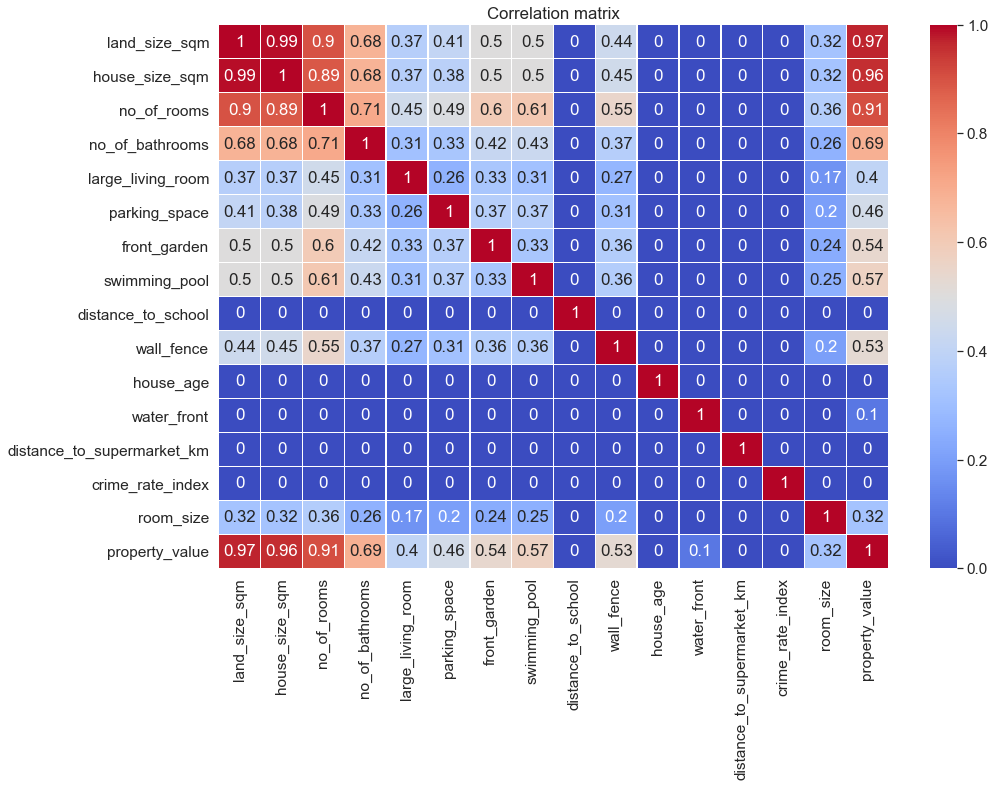

In [239]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
#print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0  

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Можем наблюдать значительную корреляцию цены домов от таких показателей, как плащадь земли, дома, количество комнат и тп, что является вполне очевидным. Однако заметим, что цена практически не коррелирует либо имеет вообще отрицательную с показателями местоположения(расстояние до магазина, школы, наличие парка рядом), уровнем преступности. Это кажется странным, поэтому исследуем зависимость цены от благоприятного местоположения домов.
Рассмотрим две подвыборки данных: А:одна с низким уровнем преступности, небольшим расстоянием до магазина и школы,  В: соответственно, с высоким показателем престпности и большими расстояниями. Исследуем параметр "property_value"

In [228]:
A_house = df[ ((df['crime_rate_index'] < 3) & (df['distance_to_supermarket_km'] < 2.5))  | ((df['distance_to_school'] < 2.5) & (df['front_garden'] == 1))] 

In [229]:
A_house.describe()

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size,property_value,group
count,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000
mean,271.101925,250.360702,4.166478,3.494337,0.767837,0.819932,0.822197,0.674972,2.263817,0.692525,11.377690,0.053228,2.651642,2.413431,1.837486,228298.974519,0.769536
std,109.772703,99.289274,1.536534,1.618842,0.422332,0.384353,0.382455,0.468518,1.858337,0.461578,6.398348,0.224551,1.977484,1.639778,0.918910,92661.964304,0.421249
min,100.000000,85.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,1.000000,0.000000,0.100000,0.010000,0.000000,51999.000000,0.000000
25%,200.000000,186.000000,3.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.000000,6.000000,0.000000,1.100000,1.060000,1.000000,165939.000000,1.000000
50%,254.000000,237.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.700000,1.000000,12.000000,0.000000,2.100000,2.135000,2.000000,219673.000000,1.000000
75%,310.750000,290.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,3.200000,1.000000,17.000000,0.000000,4.200000,3.630000,3.000000,268152.750000,1.000000
max,796.000000,737.000000,8.000000,9.000000,1.000000,1.000000,1.000000,1.000000,6.900000,1.000000,22.000000,1.000000,6.900000,5.990000,3.000000,684338.000000,1.000000


In [230]:
B_house = df[ ((df['crime_rate_index'] >= 3) & (df['distance_to_supermarket_km'] >= 2.5)) | ((df['distance_to_school'] >= 2.5) & (df['front_garden'] == 0))] 

In [231]:
B_house.describe()

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket_km,crime_rate_index,room_size,property_value,group
count,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000
mean,229.486842,212.509457,3.397615,2.926809,0.663651,0.694490,0.417763,0.559622,3.845559,0.555099,11.474918,0.044819,4.132689,3.764305,1.629112,176951.287418,0.433388
std,95.951910,88.613804,1.565321,1.537542,0.472557,0.460718,0.493292,0.496535,1.889913,0.497057,6.409400,0.206949,1.769732,1.550360,0.951618,83558.586476,0.495645
min,100.000000,87.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,1.000000,0.000000,0.100000,0.010000,0.000000,32622.000000,0.000000
25%,162.000000,149.750000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,6.000000,0.000000,2.900000,3.030000,1.000000,115053.500000,0.000000
50%,215.000000,199.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.800000,1.000000,12.000000,0.000000,4.200000,4.010000,2.000000,164032.000000,0.000000
75%,273.250000,253.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,5.500000,1.000000,17.000000,0.000000,5.600000,4.980000,2.000000,220278.000000,1.000000
max,796.000000,760.000000,8.000000,9.000000,1.000000,1.000000,1.000000,1.000000,6.900000,1.000000,22.000000,1.000000,6.900000,5.990000,3.000000,684338.000000,1.000000


In [265]:
new = pd.concat([A_house_gr, B_house_gr], ignore_index=True)
a = []
b = []
for i in range(1766):
    a.append('A')
for i in range(2432):
    b.append('B')
d = {'value': new, 
    'group': a+b }
date = pd.DataFrame(d)

In [242]:
A_house_gr = A_house['property_value']
B_house_gr = B_house['property_value']

In [244]:
print(B_house_gr.shape)
print(A_house_gr.shape)

(2432,)
(1766,)


Выборки имеют различный размер, но в целом средние показатели подходят под наше разделение.

Таким образом, вытекает гипотеза: стоимость домов выше у группы с более благоприятным местоположением.


# Проверим распределение на нормальность.

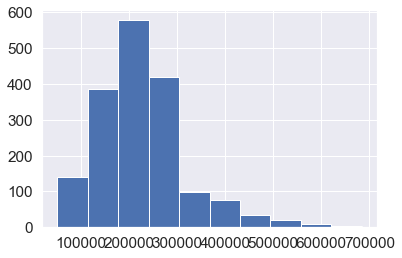

In [248]:
A_house_gr.hist()

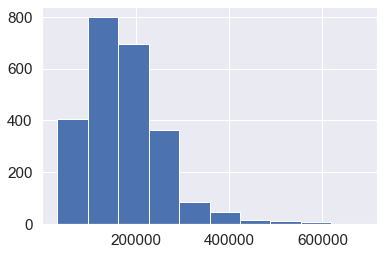

In [249]:
B_house_gr.hist()

Гистограммы имеют конусовидную форму

Воспользуемся критерием Шапиро

In [251]:
sps.shapiro(A_house_gr)

ShapiroResult(statistic=0.9287251830101013, pvalue=3.379714551789295e-28)

In [254]:
sps.shapiro(B_house_gr)

ShapiroResult(statistic=0.9073255658149719, pvalue=4.000881908012599e-36)

Полученное в ходе теста p value меньше уровня значимости 0.05, следовательно, гипотезу отвергаем. И выборки не имеют нормальный закон распределения

Посмотрим на дисперсии

In [255]:
sps.bartlett(A_house_gr, B_house_gr)

BartlettResult(statistic=22.066995142213234, pvalue=2.632981161778817e-06)

Дисперсии выборок отличаются (p-value < 0.05)

# Оценим статзначимость

In [256]:
sps.f_oneway(A_house_gr, B_house_gr)

F_onewayResult(statistic=352.2936190114863, pvalue=1.5397212333441345e-75)

Судя по p значению, матожидания выборок не равны, разница существенна


# Диаграммы размаха и гистограммы

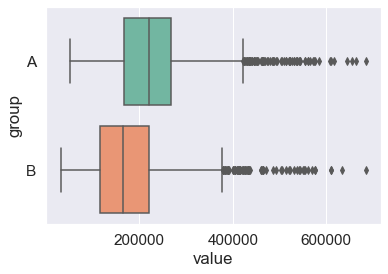

In [268]:
sns.boxplot(x = 'value', y = 'group', data = date, palette = 'Set2')

Наблюдаем в группе В уменьшение разброса значений и небольшое смещение медианы в меньшую сторону

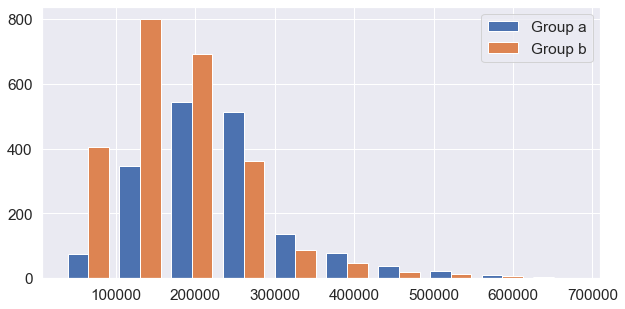

In [271]:
plt.figure(figsize=(10,5))
plt.hist([A_house_gr, B_house_gr], label=['Group a', 'Group b'])
plt.legend()
plt.show()

Наблюдаем смещение среднего(по цене) группы А в большую сторону


# Воспользуемся библиотекой Facebook Bootstrapped для нормализации наших групп

In [368]:
bs_house_a = bs.bootstrap(A_house_gr.values,
stat_func=bs_stats.mean, num_iterations=3000,
iteration_batch_size=200, return_distribution=True)

In [369]:
bs_house_b = bs.bootstrap(B_house_gr.values,
stat_func=bs_stats.mean, num_iterations=3000,
iteration_batch_size=200, return_distribution=True)

# Проверим нормальность распределения

In [370]:
alpha = 0.05
st = sps.shapiro(bs_house_a)
print('Distributions is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distributions is normal



In [371]:
alpha = 0.05
st = sps.shapiro(bs_house_b)
print('Distributions is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distributions is normal



# Проведем тест Стьюдента для проверки статзначимости

In [372]:
sps.ttest_ind(bs_house_a, bs_house_b)

Ttest_indResult(statistic=1020.2062909185441, pvalue=0.0)

p-value < 0.05 => матожидания выборок не равны, разница значительна

# Посмотрим на гистограммы и диаграмы размаха бутстрапированных выборок

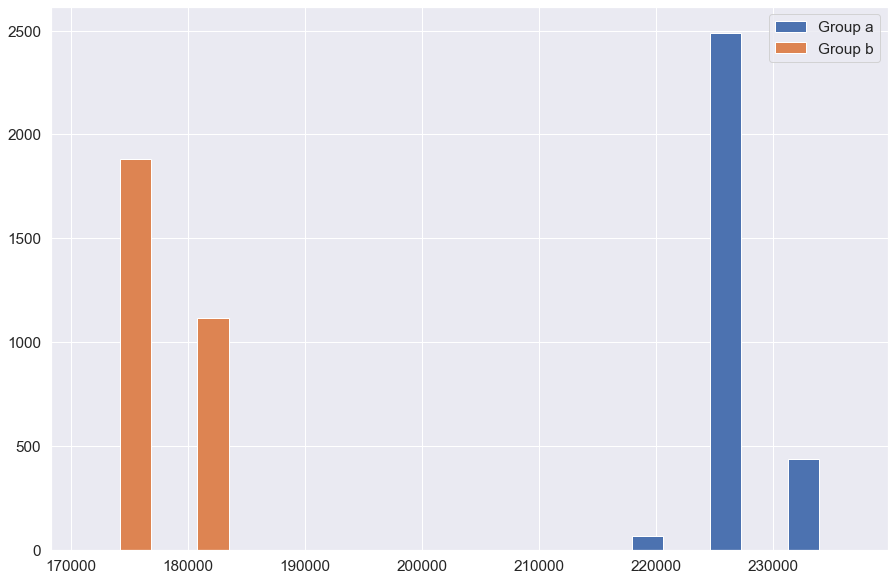

In [373]:
plt.figure(figsize=(15,10))
plt.hist([bs_house_a, bs_house_b], label=['Group a', 'Group b'])
plt.legend()
plt.show()

In [374]:
n = np.concatenate((bs_house_b, bs_house_a))
a = []
b = []
for i in range(3000):
    a.append('A')
    b.append('B')
d = {'value': n, 
    'group': a+b }
data = pd.DataFrame(d)

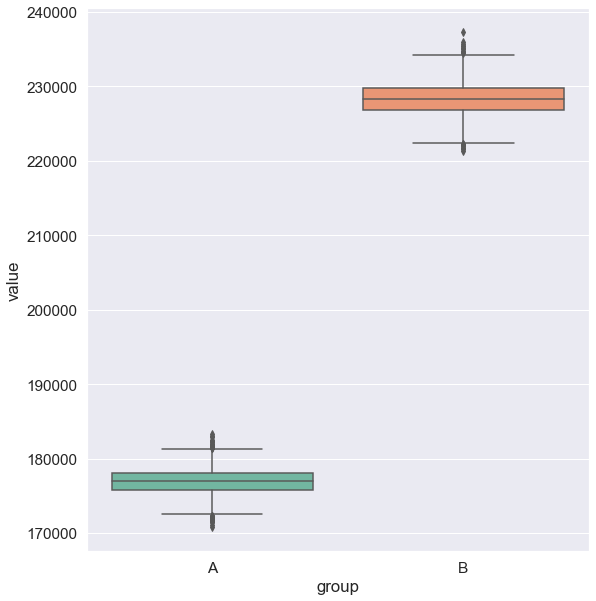

In [380]:
plt.figure(figsize=(9,10))
sns.boxplot( x = 'group', y = 'value', data = data,orient="v", palette = 'Set2')

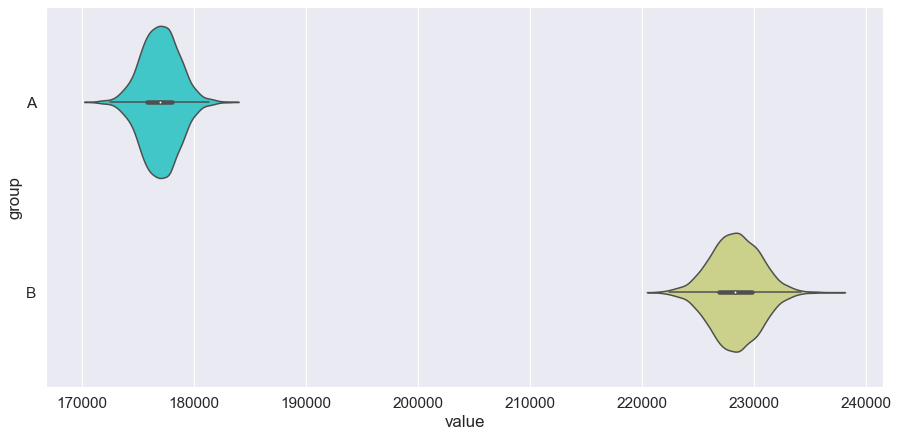

In [381]:
plt.figure(figsize=(15,7))
sns.violinplot(x="value", y="group", data=data, palette = 'rainbow')

Как видно из представленных данных, значения цены двух выборок сильно отличаются, причем среднее значение группы А значительнее больше, откуда можем сделать вывод, что цена домов зависит от местоположения: близости школы, супермаркетов и парков, а также уровня преступности. Гипотеза подтвердилась